In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pickle
from Bio import Entrez
import requests
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from collections import defaultdict
import shutil
from urllib.parse import urlparse

import gensim
import nltk
from nltk.stem import WordNetLemmatizer
np.random.seed(2018)
from nltk.stem.porter import PorterStemmer
from string import punctuation

In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
onco_df=pickle.load(open(os.path.join(base_dir, "data/Oncologist_info_1470.pkl"),"rb"))

In [3]:
center_df=pd.read_csv(os.path.join(base_dir, 'data/nci_center.csv'))

In [4]:
center_name="Memorial Sloan-Kettering Cancer Center"
onco_mskcc = onco_df.query('center_name=="{}"'.format(center_name))
onco_mskcc_list = onco_mskcc.name.values

In [5]:
center_name="Memorial Sloan-Kettering Cancer Center"

In [6]:
onco_center=center_name

In [7]:
"_".join([i.lower() for i in center_name.split()])

'memorial_sloan-kettering_cancer_center'

In [8]:
'../static/images/'+"_".join([i.lower() for i in onco_center.split()])+".png"

'../static/images/memorial_sloan-kettering_cancer_center.png'

In [9]:
onco_mskcc_list

array(['Mortimer J. Lacher', 'Kenneth H. Yu', 'Robert Sidlow',
       'Lisa Marie Ruppert', 'Carl Ola Landgren', 'Yukio Sonoda',
       'Marsha Reyngold', 'Andrea Veronica Barrio', 'Seth M. Cohen',
       'Sam S. Yoon', 'Atif J. Khan', 'Alexandra S. Heerdt',
       'William P. Tew', 'Tiffany A. Traina', 'Arlyn J. Apollo',
       'Bianca Santomasso', 'Maria Lia Palomba', 'Mark M. Souweidane',
       'Sarat Chandarlapaty', 'Zoe Goldberg', 'Sean Matthew McBride',
       'Jonathan E. Rosenberg', 'Heather Jolie Landau', 'Louise Ligresti',
       'Loren S. Michel', 'Renier J. Brentjens', 'Chau T. Dang',
       'Marcel R. M. Van Den Brink', 'Samuel Singer', 'S. Machele Donat',
       'Mahmoud El-Tamer', 'William R. Jarnagin', 'Michael P. La Quaglia',
       'Richard J. Wong', 'Paul Russo', 'Martin R. Weiser',
       'Steven Martin', 'Mario M. Leitao', 'Paul A. Hamlin',
       'Charles L. Sawyers', 'Luc Morris', 'Gregory Raskin',
       'Gregory J. Riely', 'David J. Chung', 'David B. Solit',
 

In [10]:
print(len(onco_mskcc_list))

176


In [283]:
def mskcc_name_preprocess(name):
    result = []
    temp = name.split()
    if len(temp)==3:
        if (len(temp[0])==2 and temp[0][1]=="."):
            result.append(temp[0][0].lower())
            result.append(temp[1].replace("'", "-").lower()) if "'" in temp[1] else result.append(temp[1].lower())
            result.append(temp[2].replace("'", "-").lower()) if "'" in temp[2] else result.append(temp[2].lower())
        else:
            result.append(temp[0].lower())
            result.append(temp[2].replace("'", "-").lower()) if "'" in temp[2] else result.append(temp[2].lower())
    
    else:
        for i,v in enumerate(temp):
            if len(v)==2 and v[1]=='.' and i!=0:
                continue
            elif len(v)==2 and v[1]=='.' and i==0:
                result.append(v[0].lower())
            elif "'" in v:
                result.append(v.replace("'", "-").lower())
            else:
                result.append(v.lower())
    return "-".join(result)

In [ ]:
def mskcc_name_preprocess2(name):
    result = []
    temp = name.split()
    for i in temp:
        if len(i)==2 and i[1]=='.':
            continue
        elif "'" in i:
            result.append(i.replace("'", "-").lower())
        else:
            result.append(i.lower())
    return "-".join(result)

In [178]:
a = "Carl Ola Landgren"
mskcc_name_preprocess(a)

'carl-ola-landgren'

In [138]:
onco_name1 = "Marcel R. M. Van Den Brink"
onco_name2 = "Andrea V. Barrio"
onco_name3 = "Mark E. Robson"
temp1 = mskcc_name_preprocess(onco_name1)
temp2 = mskcc_name_preprocess(onco_name2)
temp3 = mskcc_name_preprocess(onco_name3)

In [182]:
onco_name = "Mortimer J. Lacher"
temp = mskcc_name_preprocess(onco_name)
search_url=base_url.format(temp)
html = requests.get(search_url).content
soup = BeautifulSoup(html,'html.parser')

In [185]:
soup.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})

[]

In [121]:
base_url='https://www.mskcc.org/cancer-care/doctors/{}'
search_url=base_url.format(temp)

In [155]:
search_url1=base_url.format(temp1)
search_url2=base_url.format(temp2)
search_url3=base_url.format(temp3)

In [122]:
html = requests.get(search_url).content
soup = BeautifulSoup(html,'html.parser')

In [156]:
html1 = requests.get(search_url1).content
soup1 = BeautifulSoup(html1,'html.parser')

In [157]:
html2 = requests.get(search_url2).content
soup2 = BeautifulSoup(html2,'html.parser')

In [158]:
html3 = requests.get(search_url3).content
soup3 = BeautifulSoup(html3,'html.parser')

In [70]:
#soup.find_all('h2',{'class':'msk-left-rail-hero__hero-heading'})

[<h2 class="msk-left-rail-hero__hero-heading">Titles</h2>,
 <h2 class="msk-left-rail-hero__hero-heading">Clinical Expertise</h2>]

In [103]:
#"".join(soup.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").split("\n"))

### Get text description of oncologists

In [123]:
text = "".join(soup.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").replace("\xa0", "").split("\n"))
text

'I am a breast surgical oncologist who specializes exclusively in the treatment of breast diseases. I perform all aspects of breast cancer surgery. I also have extensive experience in caring for people with benign disease. I see patients at Memorial Sloan Kettering’s Evelyn H. Lauder Breast Center in New York City and at MSK Westchester. At both locations, I work closely with my colleagues in radiology, pathology, plastic surgery, medical oncology, and radiation oncology to deliver the highest quality care to our patients.Read moreDuring the past several years, my research has focused on understanding the causes of lymphedema. Lymphedema is a chronic arm swelling that may occur if all of the underarm lymph nodes have been removed. I have also studied ways to find signs of lymphedema early on in women with early-stage and advanced breast cancer. Recently, my research has been focused on reducing how often lymphedema occurs by finding ways of removing fewer underarm lymph nodes, particul

In [159]:
text = "".join(soup1.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").replace("\xa0", "").split("\n"))
text

'I am a medical oncologist and physician-scientist who specializes in bone marrow transplants as a therapy for blood cancers such as leukemia. With this treatment, also called a hematopoietic stem cell transplant, chemotherapy and radiation are used to kill the cancer in the patient’s blood and bone marrow. Then new marrow or blood stem cells are given to help healthy blood cells grow back. In the clinic, I take care of patients undergoing these transplants. In the laboratory, I study questions related to this treatment approach and to immunotherapy for cancer in general.My research is currently focused on two areas. I’m studying the role that microorganisms living in the intestine (called the microbiota) play in patients undergoing bone marrow transplants or those receiving cancer immunotherapy. I’m also developing strategies to help the body rebuild the immune system after bone marrow transplantation. The particular focus of this work is in enhancing the activity of the thymus, a sma

In [160]:
text = "".join(soup2.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").replace("\xa0", "").split("\n"))
text

'I am a breast surgical oncologist who specializes exclusively in the treatment of breast diseases. I perform all aspects of breast cancer surgery. I also have extensive experience in caring for people with benign disease. I see patients at Memorial Sloan Kettering’s Evelyn H. Lauder Breast Center in New York City and at MSK Westchester. At both locations, I work closely with my colleagues in radiology, pathology, plastic surgery, medical oncology, and radiation oncology to deliver the highest quality care to our patients.Read moreDuring the past several years, my research has focused on understanding the causes of lymphedema. Lymphedema is a chronic arm swelling that may occur if all of the underarm lymph nodes have been removed. I have also studied ways to find signs of lymphedema early on in women with early-stage and advanced breast cancer. Recently, my research has been focused on reducing how often lymphedema occurs by finding ways of removing fewer underarm lymph nodes, particul

In [141]:
text = "".join(soup3.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").replace("\xa0", "").split("\n"))
text

'I am a board-certified medical oncologist who specializes in the identification and management of individuals who have inherited an increased risk for cancer. I concentrate on helping men and women with cancer incorporate genetic information into their treatment plan. For those who are at increased risk, but have not been diagnosed, I work to develop a plan that will help them either prevent the development of cancer, or limit its impact if it occurs. Along the same lines, my research focus has studied the best ways to use genetic information to improve the outcomes of those with or at risk for hereditary cancers of all types.Read moreConsistent with the goals I pursue in my clinical genetics work, my oncology practice is weighted toward the management of young women with breast cancer, especially hereditary breast cancer. As part of that practice, I participate in the development of new treatments, such as PARP inhibitors, which may be particularly useful for this group of women. Fin

### Get clinical trials of oncologists

In [177]:
result = []
for i in soup1.find_all('span',{'class':'msk-list__content'}):
    temp = i.find_all('a')
    if len(temp)>0:
        for temp2 in temp:
            result.append(temp2.get_text())
result

[]

In [175]:
result = []
for i in soup2.find_all('span',{'class':'msk-list__content'}):
    temp = i.find_all('a')
    if len(temp)>0:
        for temp2 in temp:
            result.append(temp2.get_text())
result

['A Phase III Study of Atezolizumab Immunotherapy or Placebo plus Chemotherapy, Followed by Paclitaxel/Trastuzumab/Pertuzumab in Patients with Stage III HER2-Positive Breast Cancer that Spread to the Lymph Nodes']

In [176]:
result = []
for i in soup3.find_all('span',{'class':'msk-list__content'}):
    temp = i.find_all('a')
    if len(temp)>0:
        for temp2 in temp:
            result.append(temp2.get_text())
result

['A Phase II Study of Olaparib in Patients with Metastatic Breast Cancer with Certain Genetic Mutations',
 'A Phase I Study of Rucaparib plus Radiation Therapy in Women with Triple-Negative Breast Cancer Who Did Not Respond Completely to Presurgical Chemotherapy',
 'A Phase II Study of Avelumab Immunotherapy and Talazoparib for Patients with Advanced Cancers that Have BRCA or ATM Mutations',
 'A Phase II Study of Durvalumab and Olaparib in Patients with Triple-Negative Breast Cancer',
 'Clinical Significance of Germline BRCA Mutations',
 'Evaluating the Causes of Cancer in Young Patients']

### Get Clinical Expertise of oncologists

In [161]:
soup1.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})[0].find_all('p')[-1].get_text()

'Blood & Marrow Stem Cell Transplantation'

In [162]:
soup2.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})[0].find_all('p')[-1].get_text()

'Breast Disease'

In [163]:
soup3.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})[0].find_all('p')[-1].get_text()

'Breast Cancer; General Hematology/Oncology; Genetic Predisposition to Cancer; Cancer Risk Counseling'

### Get image of oncologists

In [240]:
onco_name="William R. Jarnagin"
temp_name = mskcc_name_preprocess(onco_name)
base_url='https://www.mskcc.org/cancer-care/doctors/{}'
search_url=base_url.format(temp_name)
html = requests.get(search_url).content
soup = BeautifulSoup(html,'html.parser')

In [248]:
image_url=soup.find_all('img',{'class':'msk-image-responsive__img'})[0].get("src")

In [251]:
from urllib.parse import urlparse

In [252]:
def is_url(url):
    try:
        result = urlparse(url)
        return all([result.scheme, result.netloc])
    except ValueError:
        return False

In [255]:
is_url(image_url)

False

In [244]:
local_file = open(os.path.join(base_dir, 'onco_image/image1.jpg'), 'wb')

In [245]:
resp.raw.decode_content = True

In [246]:
shutil.copyfileobj(resp.raw, local_file)

In [247]:
del resp

### Combined function

In [329]:
len(onco_mskcc_list)

176

In [330]:
expertise_dict={}
text_dict={}
clinical_trial_dict={}
empty_list=[]
no_img_list=[]
img_dict={}

In [331]:
def extract_onco_mskcc(onco_name):
    temp_name = mskcc_name_preprocess(onco_name)
    base_url='https://www.mskcc.org/cancer-care/doctors/{}'
    search_url=base_url.format(temp_name)
    html = requests.get(search_url).content
    soup = BeautifulSoup(html,'html.parser')
    if len(soup.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})) > 0:
        
        ## Get Clinical Expertise of oncologists
        expertise = soup.find_all('div',{'class':'msk-left-rail-hero__hero-item--content msk-left-rail-hero__hero-item'})[0].find_all('p')[-1].get_text()
        expertise_dict[onco_name] = expertise
        
        ## Get text description of oncologists
        text = "".join(soup.find_all('div',{'class':'msk-markup'})[0].get_text().replace("\xa0\n\n\n\nRead more\n\n\n\n\n", "").replace("\xa0", "").split("\n"))
        text_dict[onco_name] = text
        
        ## Get clinical trials of oncologists
        clinical_trials = []
        for i in soup.find_all('span',{'class':'msk-list__content'}):
            temp = i.find_all('a')
            if len(temp)>0:
                for temp2 in temp:
                    clinical_trials.append(temp2.get_text())
        clinical_trial_dict[onco_name] = clinical_trials
        
        ## Get image of oncologists
        img_url=soup.find_all('img',{'class':'msk-image-responsive__img'})[0].get("src")
        if is_url(img_url):
            resp = requests.get(img_url, stream=True)
            local_file = open(os.path.join(base_dir, 'onco_image/{}_img.jpg'.format(temp_name)), 'wb')
            img_dict[onco_name]='{}_img.jpg'.format(temp_name)
            resp.raw.decode_content = True
            shutil.copyfileobj(resp.raw, local_file)
            del resp
        else:
            no_img_list.append(onco_name)
    
    else:
        empty_list.append(onco_name)

In [332]:
for onco_name in onco_mskcc_list:
    extract_onco_mskcc(onco_name)
print(len(expertise_dict))

159


In [333]:
print(empty_list)
print(no_img_list)

['Mortimer J. Lacher', 'Carl Ola Landgren', 'Maria Lia Palomba', 'Mario M. Leitao', 'Gregory Raskin', 'Guenther Koehne', 'Julia Lynne Glade Bender', 'Diane Lauren Reidy', 'Jesse Joshua Smith', 'John Paul Diaz', 'Sree Bhavani Chalasani', 'Isidore Tepler', 'David Paul Kelsen', 'Peter Bach', 'Linda T. Vahda', 'Mary Susan Brady', 'Wanqing Iris Zhi']
['William R. Jarnagin']


In [334]:
onco_mskcc_dict = {"Carl Ola Landgren":"c-landgren", "Maria Lia Palomba":"m-lia-palomba", "Mario M. Leitao":"mario-leitao-jr",
                "Julia Lynne Glade Bender":"julia-glade-bender", "Diane Lauren Reidy":"diane-reidy-lagunes", "Jesse Joshua Smith":"j-smith", 
                "Sree Bhavani Chalasani":"sre-bhavani-chalasani", "David Paul Kelsen":"david-paul-kelsen", "Linda T. Vahda":"linda-vahdat", 
                "Mary Susan Brady":"mary-sue-brady", "Wanqing Iris Zhi":"iris-zhi"}

In [335]:
for onco_name in onco_mskcc_dict:
    extract_onco_mskcc(onco_mskcc_dict[onco_name])
print(len(expertise_dict))

170


In [336]:
len(img_dict)

169

In [346]:
img_dict_df=pd.DataFrame.from_dict(img_dict,orient='index').rename(columns={0:'img_name'})
img_dict_df.to_csv(os.path.join(base_dir, "data/mskcc_img_dict_df.csv"),index=True,index_label='name')

In [11]:
img_df=pd.read_csv(os.path.join(base_dir, "data/mskcc_img_dict_df.csv"),index_col='name')
img_df.head()

,img_name
name,
Kenneth H. Yu,kenneth-yu_img.jpg
Robert Sidlow,robert-sidlow_img.jpg
Lisa Marie Ruppert,lisa-ruppert_img.jpg
Yukio Sonoda,yukio-sonoda_img.jpg
Marsha Reyngold,marsha-reyngold_img.jpg


In [12]:
img_df.shape

(176, 1)

In [14]:
img_df_1=pd.read_csv(os.path.join(base_dir, "data/mskcc_img_dict_df.csv"),index_col='name')
img_df_2=pd.read_csv(os.path.join(base_dir, "data/md_img_dict_df.csv"),index_col='name')
img_df=pd.concat([img_df_1,img_df_2])

In [15]:
img_df.shape

(382, 1)

In [16]:
img_df.to_csv(os.path.join(base_dir, "data/img_dict_df.csv"),index=True,index_label='name')

In [380]:
onco_name='Kenneth Offit'
img_path = os.path.join(base_dir, 'onco_image/'+img_df.loc[onco_name].img_name)

In [382]:
img_path

'/Volumes/Yuchen_Drive/Insight/OncoMatch/onco_image/kenneth-offit_img.jpg'

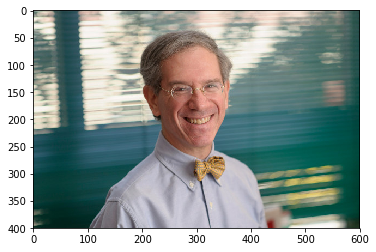

In [385]:
import matplotlib.image as mpimg
plt.imshow(mpimg.imread(img_path))

In [387]:
img_path = 'static/images/'+img_df.loc[onco_name].img_name
img_path

'static/images/kenneth-offit_img.jpg'

In [315]:
pickle.dump(expertise_dict, open(os.path.join(base_dir, "data/mskcc_expertise_dict.pkl"), "wb"))
pickle.dump(text_dict, open(os.path.join(base_dir, "data/mskcc_text_dict.pkl"), "wb"))
pickle.dump(clinical_trial_dict, open(os.path.join(base_dir, "data/mskcc_clinical_trial_dict.pkl"), "wb"))

In [317]:
expertise_dict=pickle.load(open(os.path.join(base_dir, "data/mskcc_expertise_dict.pkl"),"rb"))
text_dict=pickle.load(open(os.path.join(base_dir, "data/mskcc_text_dict.pkl"),"rb"))
clinical_trial_dict=pickle.load(open(os.path.join(base_dir, "data/mskcc_clinical_trial_dict.pkl"),"rb"))

In [342]:
len(expertise_dict)

170

In [354]:
expertise_dict_df=pd.DataFrame.from_dict(expertise_dict, orient='index').rename(columns={0:'expertise'})
expertise_dict_df.to_csv(os.path.join(base_dir, 'data/mskcc_expertise_dict_df.csv'),index=True,index_label='name')

text_dict_df=pd.DataFrame.from_dict(text_dict, orient='index').rename(columns={0:'text'})
text_dict_df.to_csv(os.path.join(base_dir, 'data/mskcc_text_dict_df.csv'),index=True,index_label='name')

clinical_trial_dict_df=pd.DataFrame.from_dict(clinical_trial_dict, orient='index')
clinical_trial_dict_df['clinical_trial'] = clinical_trial_dict_df.apply(lambda x:[i for i in x if i is not None],axis=1)
clinical_trial_dict_df = clinical_trial_dict_df.loc[:,'clinical_trial'].to_frame()
clinical_trial_dict_df.to_csv(os.path.join(base_dir, 'data/mskcc_clinical_trial_dict_df.csv'),index=True,index_label='name')

In [20]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [22]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return list(set(result))

In [21]:
def annotate_abstract(text):
    cancer_type=[]
    cancer_list1=['adrenocortical', 'anal', 'appendix', 'bladder', 'bone', 'breast', 'cervical', 'gallbladder', 'ovarian', 'penile', 'prostate', 'rectal', 'skin', 'thyroid', 'vaginal', 'vulvar', 'urethral', 'parathyroid',]
    cancer_list2=['carcinoid', 'pituitary', 'wilms', 'rhabdoid', 'brain']
    cancer_list3=['melanoma', 'mesothelioma', 'neuroblastoma', 'osteosarcoma', 'pheochromocytoma', 'retinoblastoma', 'rhabdomyosarcoma', 'sarcoma']
    for token in text:
        if token in cancer_list1:
            cancer_type.append(token.capitalize()+ ' Cancer')
        if token in cancer_list2:
            cancer_type.append(token.capitalize()+ ' Tumor')
        if token in cancer_list3:
            cancer_type.append(token.capitalize())
    if len(set(text).intersection(set(['bile','duct'])))==2:
        cancer_type.append('Bile Duct Cancer')
    if len(set(text).intersection(set(['colorectal', 'colon'])))>0:
        cancer_type.append('Colorectal Cancer')
    if len(set(text).intersection(set(['cardiac', 'heart'])))>0:
        cancer_type.append('Cardiac Tumors')
    if len(set(text).intersection(set(['endometrial', 'uterine', 'endometrium', 'uterus'])))>0:
        cancer_type.append('Endometrial Cancer')
    if len(set(text).intersection(set(['esophageal', 'esophagus'])))>0:
        cancer_type.append('Esophageal Cancer')
    if len(set(text).intersection(set(['ewing', 'sarcoma'])))==2:
        cancer_type.append('Ewing Sarcoma')
    if len(set(text).intersection(set(['fallopian', 'tube'])))==2:
        cancer_type.append('Fallopian Tube Cancer')
    if len(set(text).intersection(set(['gastric', 'stomach'])))>0:
        cancer_type.append('Gastric Cancer')
    if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))>0:
        if len(set(text).intersection(set(['gastrointestinal', 'stromal'])))==2:
            cancer_type.append('Gastrointestinal Stromal Tumor (GIST)')
        else:
            cancer_type.append('Gastrointestinal Tumor')
    if len(set(text).intersection(set(['esthesioneuroblastoma', 'hypopharyngeal', 'laryngeal', 'nasopharyngeal', 'pharyngeal', 'salivary', 'oropharyngeal', 'neck'])))>0:
        cancer_type.append('Head and Neck Cancer')
    if len(set(text).intersection(set(['kidney', 'renal'])))>0:
        cancer_type.append('Kidney Cancer')
    if 'leukemia' in text:
        cancer_type.append('Leukemia')
        if 'acute' in text:
            if 'lymphoblastic' in text:
                cancer_type.append('Acute Lymphoblastic Leukemia (ALL)')
            if 'myeloid' in text:
                cancer_type.append('Acute Myeloid Leukemia (AML)')
        if 'chronic' in text:
            if 'lymphocytic' in text:
                cancer_type.append('Chronic Lymphocytic Leukemia (CLL)')
            if 'myelogenous' in text:
                cancer_type.append('Chronic Myelogenous Leukemia (CML)')
        if 'hairy' in text:
            cancer_type.append('Hairy Cell Leukemia')
    if len(set(text).intersection(set(['liver', 'hepatocellular', 'hepatocyte', 'hepatoblastoma'])))>0:
        cancer_type.append('Liver Cancer')
    if len(set(text).intersection(set(['lung', 'bronchial', 'pleuropulmonar', 'tracheobronchial'])))>0:
        cancer_type.append('Lung Cancer')
    if 'lymphoma' in text:
        cancer_type.append('Lymphoma')
        if 'burkitt' in text:
            cancer_type.append('Burkitt Lymphoma')
        if len(set(text).intersection(set(['mycosis', 'fungoides'])))==2:
            cancer_type.append('Mycosis Fungoides')
    if len(set(text).intersection(set(['multiple', 'myeloma'])))==2:
        cancer_type.append('Multiple Myeloma')
    if len(set(text).intersection(set(['myeloproliferative', 'myelodysplastic'])))>0:
        cancer_type.append('Myeloproliferative Neoplasms')
    if len(set(text).intersection(set(['pancreatic', 'pancreas'])))>0:
        cancer_type.append('Pancreatic Cancer')
    if len(set(text).intersection(set(['testicular', 'testicle', 'testicles', 'testis'])))>0:
        cancer_type.append('Testicular Cancer')
    return cancer_type

In [27]:
expertise_dict_df=pd.read_csv(os.path.join(base_dir, 'data/mskcc_expertise_dict_df.csv'),index_col='name')
expertise_dict_df.head()

,expertise
name,
Kenneth H. Yu,"Pancreatic, Hepatobiliary, and Other Gastroint..."
Robert Sidlow,"Head, Division of Survivorship and Supportive ..."
Lisa Marie Ruppert,Cancer Rehabilitation; Spinal Cord Injury Medi...
Yukio Sonoda,Ovarian Cancer; Uterine Cancer; Cervical Cance...
Marsha Reyngold,Breast Cancer; Gastrointestinal Cancer; Intens...


In [34]:
expertise_dict_df['expertisen_processed']=expertise_dict_df.expertise.apply(lambda x:preprocess(x))
expertise_dict_df['cancer_type2']=expertise_dict_df.expertisen_processed.apply(lambda x:annotate_abstract(x))     

In [35]:
expertise_dict_df.head()

,expertise,expertisen_processed,cancer_type2
name,,,
Kenneth H. Yu,"Pancreatic, Hepatobiliary, and Other Gastroint...","[pancreatic, malignancy, hepatobiliary]",[Pancreatic Cancer]
Robert Sidlow,"Head, Division of Survivorship and Supportive ...","[operation, chair, care, head, associate, surv...",[]
Lisa Marie Ruppert,Cancer Rehabilitation; Spinal Cord Injury Medi...,"[injury, rehabilitation, medicine, cord, spinal]",[]
Yukio Sonoda,Ovarian Cancer; Uterine Cancer; Cervical Cance...,"[surgery, invasive, ovarian, radical, uterine,...","[Ovarian Cancer, Vulvar Cancer, Vaginal Cancer..."
Marsha Reyngold,Breast Cancer; Gastrointestinal Cancer; Intens...,"[therapy, radiation, radiosurgery, intensity, ...",[Breast Cancer]


In [358]:
text_dict_df=pd.read_csv(os.path.join(base_dir, 'data/mskcc_text_dict_df.csv'),index_col='name')
text_dict_df.head()

,text
name,
Kenneth H. Yu,I am a medical oncologist with expertise in th...
Robert Sidlow,I am a board-certified general internist and p...
Lisa Marie Ruppert,I am a physician of Physical Medicine and Reha...
Yukio Sonoda,I am a gynecologic oncologist who performs abo...
Marsha Reyngold,I am a board-certified radiation oncologist wh...


In [370]:
clinical_trial_dict_df=pd.read_csv(os.path.join(base_dir, 'data/mskcc_clinical_trial_dict_df.csv'),index_col='name')
clinical_trial_dict_df.head()

,clinical_trial
name,
Kenneth H. Yu,"['A Phase IB Study of Armed, Activated T Cells..."
Robert Sidlow,[]
Lisa Marie Ruppert,[]
Yukio Sonoda,[]
Marsha Reyngold,['A Phase II Study Assessing High-Dose Radiati...


In [318]:
#df1 = pd.DataFrame.from_dict(expertise_dict, orient='index', columns=['Clinical Expertise'])
#df2 = pd.DataFrame.from_dict(text_dict, orient='index', columns=['About Me'])
#df3 = pd.DataFrame.from_dict(clinical_trial_dict, orient='index', columns=['Clinical Trials'])

In [314]:
len(clinical_trial_dict)

170

In [ ]:
lda_summary_df=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=1,sort=False)

In [321]:
clinical_trial_dict['Kenneth H. Yu']

['A Phase IB Study of Armed, Activated T Cells in Patients with Advanced Pancreatic Cancer',
 'A Phase II Study of Cabiralizumab plus Nivolumab Immunotherapy with or without Chemotherapy in Patients with Advanced Pancreatic Cancer',
 'A Pilot Study of Gemcitabine, Nab-Paclitaxel, PEGPH20, and Rivaroxaban for Advanced Pancreatic Cancer',
 'A Phase IB/II Study Assessing Multiple Immunotherapy Treatments in Patients with Metastatic Pancreatic Cancer',
 'A Phase IB/II Study of APX005M Immunotherapy plus Gemcitabine and nab-Paclitaxel, with or without Nivolumab, in Patients with Previously Untreated Metastatic Pancreatic Cancer']

In [324]:
onco_name = "Kenneth H. Yu"

In [325]:
#base_url='https://clinicaltrials.gov/ct2/results?term=Kenneth+H.+Yu&cond=Cancer&cntry=US&Search=Apply&recrs=b&recrs=a&recrs=f&recrs=d&recrs=e&age_v=&gndr=&type=&rslt='
base_url='https://clinicaltrials.gov/ct2/results?term={}&cond=Cancer&cntry=US&Search=Apply&recrs=b&recrs=a&recrs=f&recrs=d&recrs=e&age_v=&gndr=&type=&rslt='
search_url=base_url.format("+".join(onco_name.split()))

In [326]:
html = requests.get(search_url).content
soup = BeautifulSoup(html,'html.parser')